# Notebook to demonstrate multiscale cleaning on the canonical "M31" source.

We simulate some VLA data for M31 and then use msclean to restore it.

Multiscale CLEAN, (IEEE Journal of Selected Topics in Sig Proc, 2008 vol. 2 pp. 793-801)

In [1]:
%matplotlib inline

import sys, os 
sys.path.append(os.path.join('..','..')) 

import pylab
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

from timeit import default_timer as timer

import numpy
import scipy
import scipy.special

from matplotlib import pylab
from matplotlib import pyplot as plt

import pyfits

from crocodile.synthesis import *
from crocodile.simulate import *
from util.visualize import *
from crocodile.msclean import *

Now generate and plot the uvw coordinates

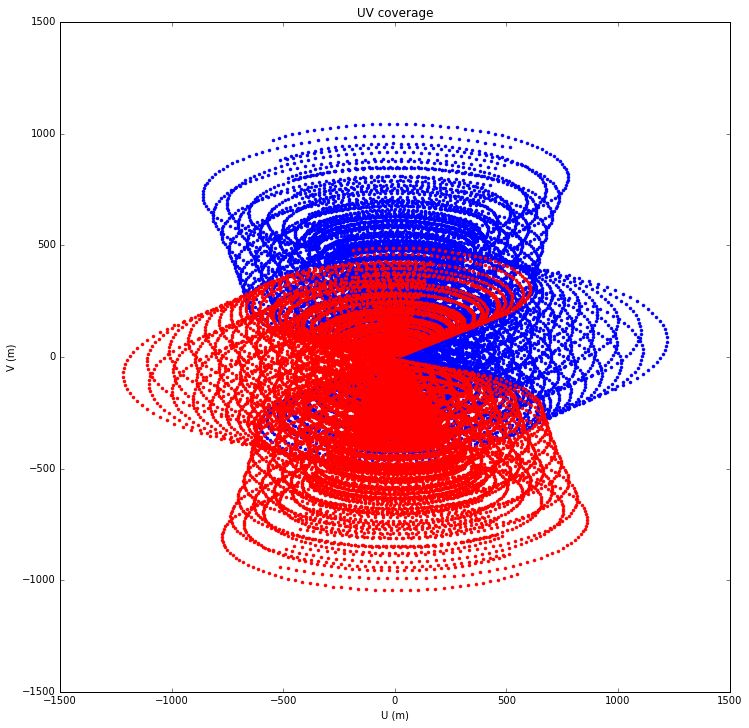

In [2]:
vlas=numpy.genfromtxt("../../data/vis/VLA_A_hor_xyz.txt", delimiter=",") 
vlas_xyz = xyz_at_latitude(vlas, numpy.pi*34.0784/180.0)/30.0 
uvw=xyz_to_baselines(vlas_xyz, numpy.arange(-numpy.pi/2.0, +numpy.pi/2.0,0.05), numpy.pi/10)
plt.clf()
plt.plot(uvw[:,0],uvw[:,1], '.')
plt.plot(-uvw[:,0],-uvw[:,1], '.', color='red')
plt.xlabel('U (m)')
plt.ylabel('V (m)')
plt.title('UV coverage')

Next get the M31 model from the crocodile data directory

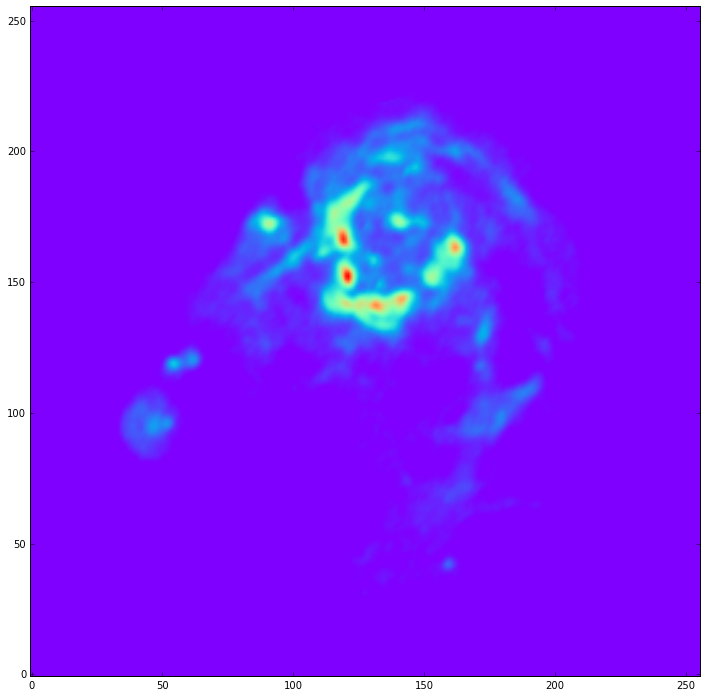

In [3]:
m31model='../../data/models/M31.MOD'
hdulist = pyfits.open(m31model)
m31image=numpy.array(hdulist[0].data)
plt.clf()
plt.imshow(m31image, cmap='rainbow', origin='lower')
plt.show()

Calculate the visibility for m31 using wslicfwd

In [4]:
lam=4.0*numpy.abs(uvw).max()
cell=1.0/lam
theta=256*cell
wstep=100

print("Field of view = %.2f degrees, maximum baseline %.3f (m)" % (theta*180.0/numpy.pi, lam))

Field of view = 3.01 degrees, maximum baseline 4870.368 (m)


The prediction and imaging steps use a least-recently-used cache of the w convolution kernels.
Here we set up the cache and pre-fill it

In [5]:
wcachesize=int(numpy.ceil(numpy.abs(uvw[:,2]).max()/wstep))
print("Making w-kernel cache of %d kernels" % (wcachesize))
wcache=pylru.FunctionCacheManager(lambda iw: wkernaf(N=256, theta=theta, w=iw*wstep, s=15, Qpx=4), 10000)

start = timer()
for iw in range(-wcachesize,wcachesize):
    wg=wcache(iw)
mid = timer()

print("First call took %.3f (s)" % (mid-start))

for iw in range(-wcachesize,wcachesize):
    wg=wcache(iw)

end = timer()
print("Second call took %.3f (s)" % (end-mid))

Making w-kernel cache of 12 kernels
First call took 3.824 (s)
Second call took 0.000 (s)


Now we can define the prediction and imaging functions that will use this cache

In [6]:
predfn=lambda *x: wcachefwd(*x, wstep=wstep, wcache=wcache)
imgfn=lambda *x: wcacheimg(*x, wstep=wstep, wcache=wcache)

Now we predict the visibility data using the w-kernels cache.

In [7]:
uvw[0]

array([-11.56928759,  -6.78246683, -34.33323217])

In [8]:
uvwsort,vobs=dopredict(theta, lam, p=uvw, modelimage=m31image, predfn=predfn)

Plot the visibility as a function of uv distance

(22113, 3)
(22113,)
(22113,)


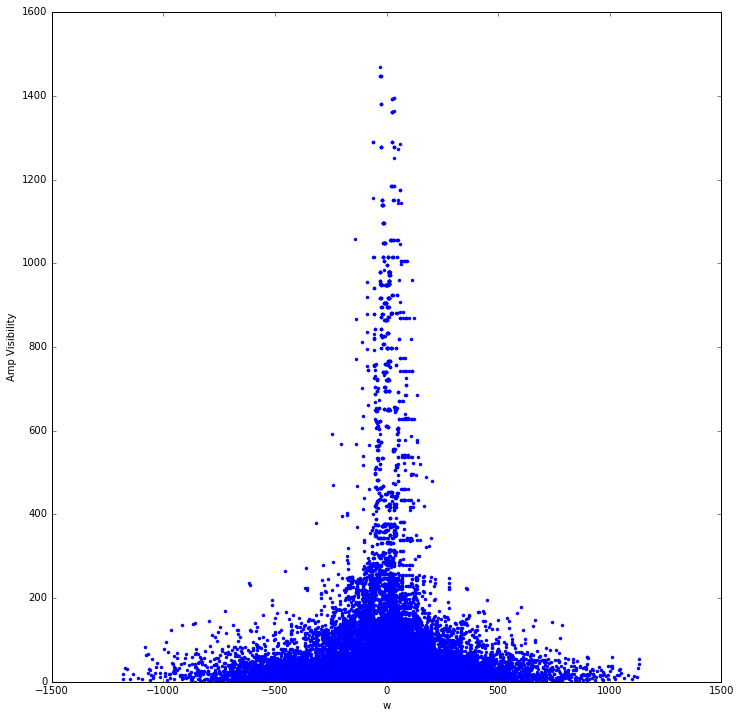

In [9]:
print(uvwsort.shape)
print(uvwsort[:,2].shape)

print(vobs.shape)

uvdist=numpy.sqrt(uvwsort[:,0]*uvwsort[:,0]+uvwsort[:,1]*uvwsort[:,1])
plt.clf()
plt.plot(uvwsort[:,2], numpy.abs(vobs), '.')
plt.xlabel('w')
plt.ylabel('Amp Visibility')
plt.show()

Next we make the dirty image and psf to check if it looks plausible

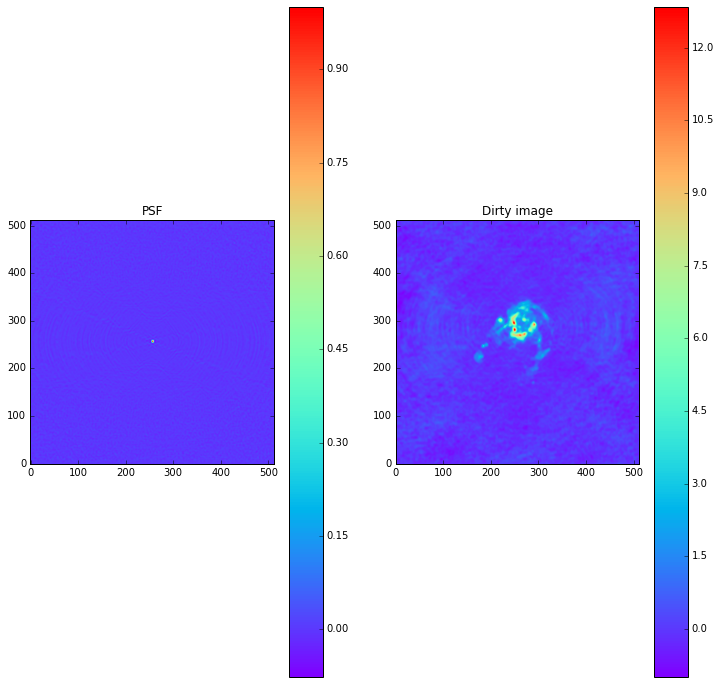

In [10]:
d,p,sumwt=doimg(2.0*theta, lam, uvwsort, vobs, imgfn=imgfn)
plt.clf()
plt.subplot(1,2,1)
plt.imshow(p, cmap='rainbow', origin='lower')
plt.title('PSF')
c=plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(d, cmap='rainbow', origin='lower')
plt.title('Dirty image')
c=plt.colorbar()

Now we can do the deconvolution

Start of major cycle 0
Peak of PSF = 1.0 at (256, 256)
Peak of Dirty = 12.8388315886 at (280, 249)
Coupling matrix =
 [[ 1.          0.9654654   0.59725449  0.11333109]
 [ 0.9654654   0.93280706  0.5827434   0.11273858]
 [ 0.59725449  0.5827434   0.41421562  0.10430458]
 [ 0.11333109  0.11273858  0.10430458  0.06133371]]
Max abs in dirty Image = 12.838832
Start of minor cycle
This minor cycle will stop at 1000 iterations or peak < 1.28388315886
Minor cycle 0, peak [ 10.57246566  10.50469753   9.66503083   7.12220301] at [268, 260, 3]
Minor cycle 10, peak [ 4.55495792  4.52816348  4.17936701  3.13421741] at [326, 267, 3]
Minor cycle 20, peak [ 3.11844215  3.09104515  2.73480565  1.58860322] at [260, 300, 3]
Minor cycle 30, peak [ 2.39981827  2.38158856  2.13595486  1.13310982] at [269, 240, 3]
Minor cycle 40, peak [ 1.35520031  1.34863757  1.26345453  0.85911718] at [320, 304, 3]
Minor cycle 50, peak [ 2.49328649  2.46040953  2.02563147  0.68170511] at [281, 279, 3]
Minor cycle 60, peak

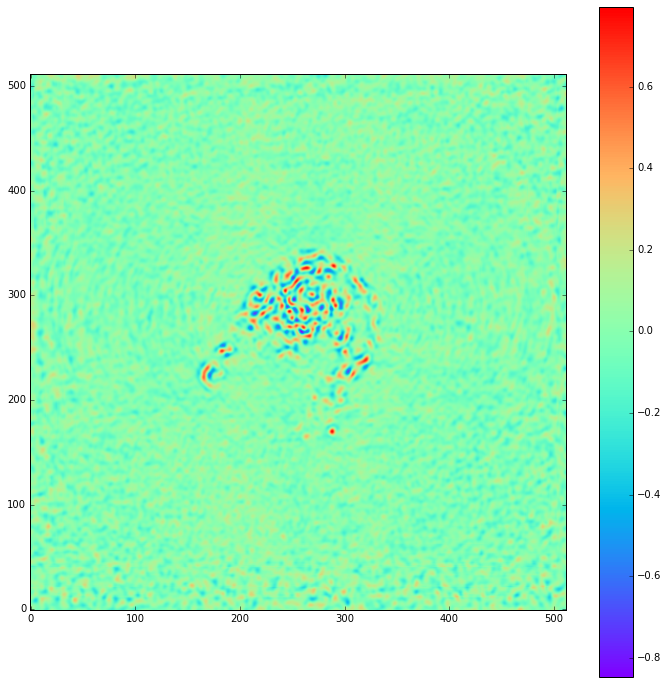

End of major cycle
Start of major cycle 1
Peak of PSF = 1.0 at (256, 256)
Peak of Dirty = 0.791974418679 at (285, 259)
Coupling matrix =
 [[ 1.          0.96546559  0.59725614  0.11333248]
 [ 0.96546559  0.93280742  0.58274507  0.11273997]
 [ 0.59725614  0.58274507  0.41421745  0.10430594]
 [ 0.11333248  0.11273997  0.10430594  0.06133486]]
Max abs in dirty Image = 0.844080
Start of minor cycle
This minor cycle will stop at 1000 iterations or peak < 0.2
Minor cycle 0, peak [-0.77578017 -0.77196966 -0.71872201 -0.46763724] at [243, 16, 3]
Minor cycle 10, peak [ 0.42787557  0.42546824  0.39415738  0.27873931] at [122, 497, 3]
Minor cycle 20, peak [ 0.37645714  0.37646582  0.36894447  0.24438804] at [20, 425, 3]
Minor cycle 30, peak [ 0.27307742  0.2737059   0.27458159  0.22087519] at [425, 6, 3]
Minor cycle 40, peak [ 0.35823022  0.3548266   0.3144525   0.18553413] at [373, 10, 3]
Minor cycle 50, peak [-0.32614012 -0.32271114 -0.28028356 -0.17160687] at [216, 22, 3]
Minor cycle 60, peak 

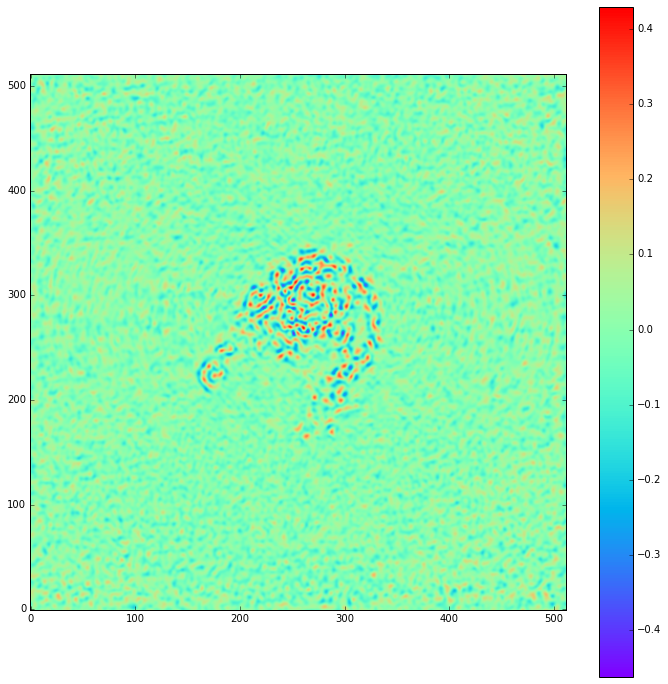

End of major cycle
Start of major cycle 2
Peak of PSF = 1.0 at (256, 256)
Peak of Dirty = 0.572693570892 at (295, 288)
Coupling matrix =
 [[ 1.          0.9654654   0.59725449  0.11333109]
 [ 0.9654654   0.93280706  0.5827434   0.11273858]
 [ 0.59725449  0.5827434   0.41421562  0.10430458]
 [ 0.11333109  0.11273858  0.10430458  0.06133371]]
Max abs in dirty Image = 0.572694
Start of minor cycle
This minor cycle will stop at 1000 iterations or peak < 0.2
Minor cycle 0, peak [-0.24624259 -0.24567425 -0.23696294 -0.16818654] at [121, 496, 3]
Minor cycle 10, peak [-0.17044055 -0.16923079 -0.15437506 -0.1056827 ] at [342, 86, 3]
Minor cycle 20, peak [-0.21492548 -0.21320027 -0.18946452 -0.09430327] at [16, 392, 3]
Minor cycle 30, peak [ 0.22793563  0.22488656  0.1844003   0.08311329] at [327, 261, 3]
Minor cycle 40, peak [ 0.08796132  0.08904201  0.09856649  0.07702247] at [19, 208, 3]
Minor cycle 50, peak [ 0.17241647  0.17218137  0.1626096   0.07383091] at [494, 492, 3]
Minor cycle 60, pe

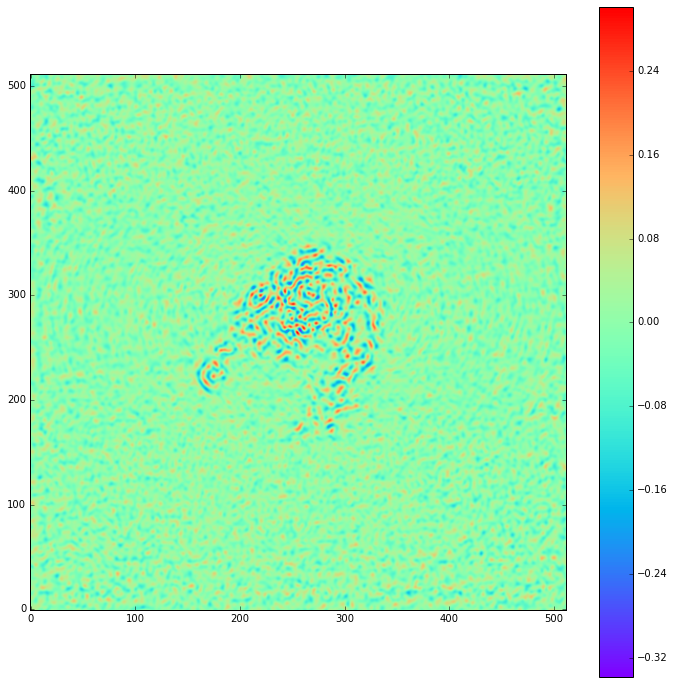

End of major cycle
End of major cycles


In [11]:
scales=[0, 3, 10, 30]
ps, vs, m31cc, m31res=majorcycle(2.0*theta, lam, uvwsort, vobs, 0.75, 3, 1000, scales, 0.20, 0.1, \
                                 predfn=predfn, \
                                 imgfn=imgfn)

Finally show the results

Total flux in model 1330.081854 Jy


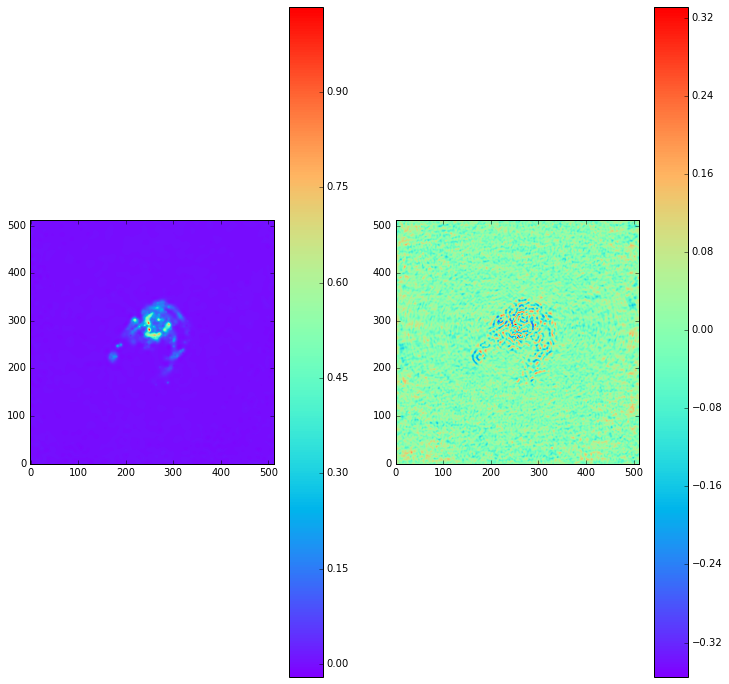

In [15]:
print("Total flux in model %.6f Jy" % numpy.sum(m31cc))
plt.clf()
plt.subplot(1,2,1)
plt.imshow(m31cc, cmap='rainbow', origin='lower')
c=plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(m31res, cmap='rainbow', origin='lower')
c=plt.colorbar()

Now plot the residual visibility to see if it is noise-like

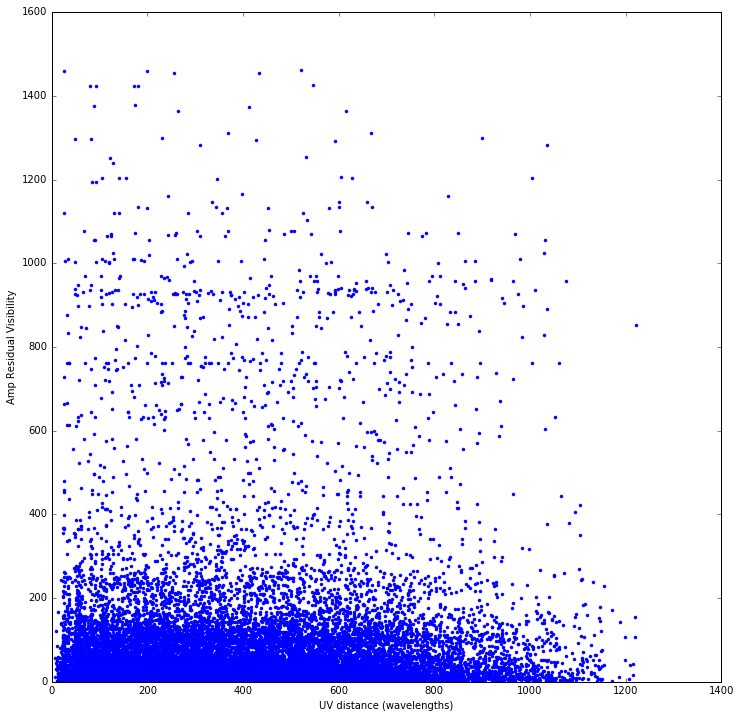

In [16]:
plt.clf()
plt.plot(uvdist, numpy.abs(vs), '.')
plt.xlabel('UV distance (wavelengths)')
plt.ylabel('Amp Residual Visibility')
plt.show()

Plot against w to see if the errors are more easily seen

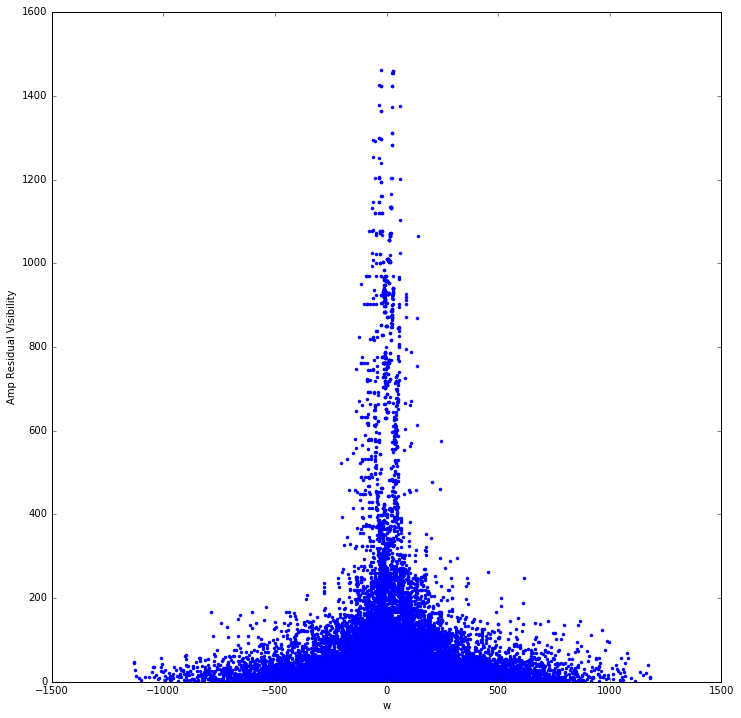

In [14]:
plt.clf()
plt.plot(ps[:,2], numpy.abs(vs), '.')
plt.xlabel('w')
plt.ylabel('Amp Residual Visibility')
plt.show()